### Version
2021/02/13 First edition
- parsing function
- select 9 particle features and 7 jet features
- pad to 64 particles per jet
- set threshold to 64 particles
- get 5000 data

2021/02/15
- choose 7 particle features ( without type and pid ) and 7 jet features
- normalize to 2*PI

# Get particles information in a jet

This code is going to extract the data we need in getting particles data in jets. We are going to select data with particles less than or equal to 64 (since most of the jet is <= 64). Also, we pad each input data as 9 features of each particle in one particular jet and 7 features of the jet. For the jet that the particle numbers is less than 64, we'll pad them as zero 9 features but still 7 features of the jet. Since this data is going to use on the circuit design for find correlation ,e.g., finding the subtraction of 2 input, so that the remaining 7 features will cancel out.

## Import modules

In [7]:
import numpy as np
import os, gzip, sys
import matplotlib.pyplot as plt
from ParseJetData import parse_jet_data # for parsing jet data

## Select data needed to save in npy

For each d, c in parse_jet_data(fin)
- d : information for the particular jet (a dictionary).
- c : list of particles in the particular jet, each with 10 elements. 

 1. index 
 2. type(0:gen/1:track/2:Ecal/3:Hcal)
 3. pid
 4. charge
 5. pt
 6. eta
 7. phi
 8. vx
 9. vy
10. vz

In [8]:
def jet_to_npy(filename, number=5000, threshold=64):
    filename = os.path.join(os.getcwd(), filename)
    fin = gzip.open(filename)
    count = 0
    jets_data = []
    bin_count = np.zeros(200)
    while count < number:
        d, c = parse_jet_data(fin) # get data from a jet
        bin_count[c.shape[0]] += 1 # for counting particles number
        jet_data = []
        # pick 9 each particle information (0-8) type, pid, charge, pt, eta, phi, vx, vy, vz
        # choose only particles less or equal than 64
        if c.shape[0] <= 64:
            info = np.zeros(7)
            count += 1
            # 7 global information (9-15) mass, pt, eta, phi, deltaeta, deltaphi, charge
            info[0] = d['mass']
            info[1] = d['pt']
            info[2] = d['eta']
            info[3] = d['phi']
            info[4] = d['deltaeta']
            info[5] = d['deltaphi']
            info[6] = d['charge']
            for index in range(c.shape[0]):
                c_pick = c[index][1:]
                c_extend = np.r_[c_pick, info]
                jet_data.append(list(c_extend))
            # pad each jet data to 64 particles, with padding = empty particle
            for padding in range(64-c.shape[0]):
                c_extend = np.r_[np.zeros(9), info]
                jet_data.append(list(c_extend))
            jets_data.append(jet_data)
    jets_data = np.array(jets_data)
    return jets_data, bin_count

## Check the data we selected

In this data, since most of the number of particles in a jet is less than or equal to 64, we choose the threshold to be 64. For detail, see the plot below.

shape of sig_data : (200, 64, 16)
shape of bkg_data : (200, 64, 16)


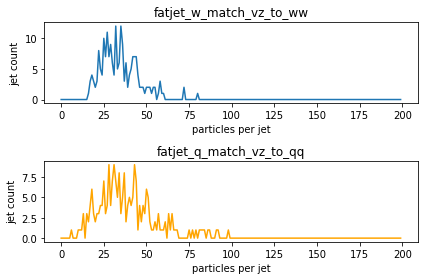

In [23]:
SRC_SIG = {'filename':'jet_data/fatjet_w_match_vz_to_ww.txt.gz', 'skip':0, 'n':6000} # 166
SRC_BKG = {'filename':'jet_data/fatjet_q_match_vz_to_qq.txt.gz', 'skip':0, 'n':6000} # 157

data_number = 200
sig_data, sig_count = jet_to_npy(filename = SRC_SIG['filename'], number = data_number, threshold = 64)
bkg_data, bkg_count = jet_to_npy(filename = SRC_BKG['filename'], number = data_number, threshold = 64)

print(f"shape of sig_data : {sig_data.shape}")
print(f"shape of bkg_data : {bkg_data.shape}")

fig, axs = plt.subplots(2,1)

plt.subplot(axs[0])
plt.title('fatjet_w_match_vz_to_ww')
plt.xlabel('particles per jet')
plt.ylabel('jet count')
plt.plot(range(200), sig_count)

plt.subplot(axs[1])
plt.title('fatjet_q_match_vz_to_qq')
plt.xlabel('particles per jet')
plt.ylabel('jet count')
plt.plot(range(200), bkg_count, color='orange')

plt.tight_layout()

In [24]:
# uncomment to create original data with
# sig_path = os.path.join(os.getcwd(), "jet_data/QML_VQC_Thres64_Feat16_9P_7J_fatjet_w.npy")
# bkg_path = os.path.join(os.getcwd(), "jet_data/QML_VQC_Thres64_Feat16_9P_7J_fatjet_q.npy")
# np.save(sig_path, sig_data)
# np.save(bkg_path, bkg_data)

# ---------------------------------------------------------------------------------------------
'''
these lines is going to select feature without type and pid
(0-8) type, pid, charge, pt, eta, phi, vx, vy, vz
(9-15) mass, pt, eta, phi, deltaeta, deltaphi, charge
after selected :
(0-13) charge, pt, eta, phi, vx, vy, vz , g_mass, g_pt, g_eta, g_phi, g_deltaeta, g_deltaphi, g_charge
'''
for i in range(data_number):
    # shape is (data_number, 64, 16)
    for j in range(64):
        # move the feature forward
        sig_data[i][j][:-2] = sig_data[i][j][2:]
        bkg_data[i][j][:-2] = bkg_data[i][j][2:]
        # set last two to constant
        sig_data[i][j][-2:] = np.zeros(2)
        bkg_data[i][j][-2:] = np.zeros(2)
sig_path = os.path.join(os.getcwd(), "jet_data/QML_VQC_Thres64_Feat16_7P_7J_2C_fatjet_w.npy")
bkg_path = os.path.join(os.getcwd(), "jet_data/QML_VQC_Thres64_Feat16_7P_7J_2C_fatjet_q.npy")
np.save(sig_path, sig_data)
np.save(bkg_path, bkg_data)

# Load the data for checking
sig_load = np.load(sig_path)
bkg_load = np.load(bkg_path)
print(f"sig data shape : {sig_load.shape}")
print(f"bkg data shape : {bkg_load.shape}")
for i in range(5):
    print("sig loading:")
    print(sig_load[i][:3])
    print("bkg loading:")
    print(bkg_load[i][:3])

sig data shape : (200, 64, 16)
bkg data shape : (200, 64, 16)
sig loading:
[[ 1.00000000e+00  1.32383002e-03  4.05852870e-01 -1.59197240e-01
   1.23570190e+01  3.84721110e+00  7.66279600e+00  9.03602370e+01
   1.13376550e+03  2.00991320e-01  5.22086500e-01  4.05852880e-01
   2.11638530e-01  2.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.09628279e-02  1.32447940e-01  2.11638510e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  9.03602370e+01
   1.13376550e+03  2.00991320e-01  5.22086500e-01  4.05852880e-01
   2.11638530e-01  2.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  1.63133743e-03  1.40062850e-01  1.64811790e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  9.03602370e+01
   1.13376550e+03  2.00991320e-01  5.22086500e-01  4.05852880e-01
   2.11638530e-01  2.00000000e+00  0.00000000e+00  0.00000000e+00]]
bkg loading:
[[ 0.00000000e+00  4.75820904e-03  1.89150690e-01 -1.47983800e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00 